# NFL Big Data Bowl Clustering

## Import data

In [1]:
import pandas as pd

In [2]:
plays = pd.read_csv('~/Documents/NFL/Data/nfl-big-data-bowl-2022/plays.csv')
games = pd.read_csv('~/Documents/NFL/Data/nfl-big-data-bowl-2022/games.csv')
players = pd.read_csv('~/Documents/NFL/Data/nfl-big-data-bowl-2022/players.csv')
tracking2018 = pd.read_csv('~/Documents/NFL/Data/nfl-big-data-bowl-2022/fg_tracking_2018.csv')
tracking2019 = pd.read_csv('~/Documents/NFL/Data/nfl-big-data-bowl-2022/fg_tracking_2019.csv')
tracking2020 = pd.read_csv('~/Documents/NFL/Data/nfl-big-data-bowl-2022/fg_tracking_2020.csv')

## Preprocess Players Data

In [3]:
from Preprocessing_makers import preprocess_players

In [4]:
players_df = preprocess_players(players)

## Preprocess Tracking Data

In [5]:
from Preprocessing_makers import preprocess_tracking, preprocess_football_track

In [6]:
fg_tracking_2018, fg_tracking_2019, fg_tracking_2020 = preprocess_tracking(tracking2018, tracking2019, tracking2020, plays, 'Field Goal')

In [7]:
fg_tracking_ball = preprocess_football_track(fg_tracking_2018, fg_tracking_2019, fg_tracking_2020)

## Preprocess Play Data

In [8]:
from Preprocessing_makers import preprocess_play
from Cleaning_data import drop_by_index_difference

In [9]:
play_df = preprocess_play(plays)

In [10]:
play_df = drop_by_index_difference(play_df, fg_tracking_ball, 'field_goal_attempt')

## Make Field Goal DataFrame

In [11]:
from Preprocessing_makers import make_fieldGoal

In [12]:
field_goal_df = make_fieldGoal(play_df, players_df)

## Feature Engineering

In [13]:
from Feature_engineering import endzone_y_pos, expected_endzone_y_pos, kicker_core_dist, exp_err_y, off_center

### Fieldgoal Y-Position

In [14]:
field_goal_df = endzone_y_pos(field_goal_df, fg_tracking_ball)

### Fieldgoal Trajectory Position

In [15]:
attempts_df = field_goal_df[field_goal_df['specialTeamsResult'].isin(['Kick Attempt Good', 'Kick Attempt No Good'])]

In [16]:
attempts_ids = attempts_df[['gameId', 'playId']]

In [17]:
attempts_tracking = pd.merge(attempts_ids, fg_tracking_ball, left_on = ['gameId', 'playId'], right_on = ['gameId', 'playId'])

In [18]:
attempts_event = attempts_tracking[attempts_tracking['event']=='field_goal_attempt']

In [19]:
attempts_event['mergeId'] = attempts_event['gameId'].astype(str) + attempts_event['playId'].astype(str)
attempts_ids['mergeId'] = attempts_ids['gameId'].astype(str) + attempts_ids['playId'].astype(str)

/tmp/ipykernel_58566/3006702610.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  attempts_event['mergeId'] = attempts_event['gameId'].astype(str) + attempts_event['playId'].astype(str)
/tmp/ipykernel_58566/3006702610.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  attempts_ids['mergeId'] = attempts_ids['gameId'].astype(str) + attempts_ids['playId'].astype(str)


In [20]:
indices_to_drop = attempts_ids[~attempts_ids['mergeId'].isin(attempts_event['mergeId'])].index

In [21]:
#fg_tracking_ball[(fg_tracking_ball['gameId']==2018122302) & (fg_tracking_ball['playId']==1858)]

In [22]:
#fg_tracking_ball = fg_tracking_ball.drop(indices_to_drop)

In [23]:
attempts_df = attempts_df.drop(indices_to_drop)

In [24]:
attempts_df = expected_endzone_y_pos(attempts_df, fg_tracking_ball, 'field_goal_attempt')

### Kicker Core Distance

While performing this compute, I discovered that it is apparently possible for a kicker not to be present for a play (???????????).

For an example of where this occurs, check out `gameId = 2019091502` and `playId = 2075` in the 2019 tracking data.

In [25]:
attempts_df = kicker_core_dist(attempts_df, fg_tracking_2018, fg_tracking_2019, fg_tracking_2020, fg_tracking_ball, 'field_goal_attempt', k=3)

/home/kenneth/Documents/NFL/NFL_BDB_2022/Feature_engineering.py:338: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  opposing_team_players['kicker_dist'] = l2_norm(kicker_x, kicker_y, opposing_team_players['x'], opposing_team_players['y'])


### Endzone Y-Position Off-Center

In [26]:
attempts_df = off_center(attempts_df)

### Endzone Y-Position Trajectory Error

In [27]:
attempts_df = exp_err_y(attempts_df)

## Final Preprocessing Steps

In [28]:
from Preprocessing_makers import preprocess_fg

In [29]:
X, final_df = preprocess_fg(attempts_df)

## Clustering

In [30]:
import hdbscan

import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
model = hdbscan.HDBSCAN()

In [32]:
model_results = model.fit(X)

In [33]:
model_results.labels_.max()

4

In [34]:
final_df['cluster_id'] = model_results.labels_

In [35]:
final_df['cluster_id'].value_counts()

 4    1858
-1     306
 2     106
 3      68
 0      17
 1      16
Name: cluster_id, dtype: int64

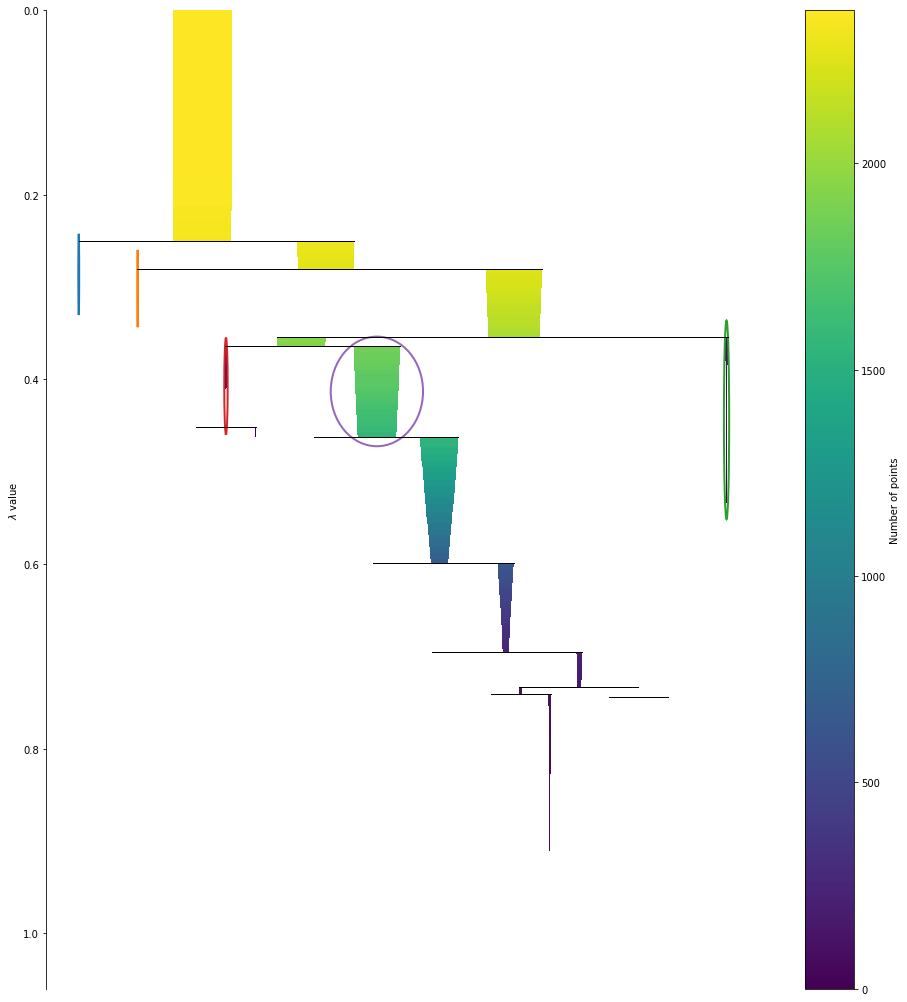

In [36]:
plt.figure(figsize = (16,18))
model.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())
plt.show()

In [37]:
cluster0 = final_df[final_df['cluster_id']==0]
cluster1 = final_df[final_df['cluster_id']==1]
cluster2 = final_df[final_df['cluster_id']==2]
cluster3 = final_df[final_df['cluster_id']==3]
cluster4 = final_df[final_df['cluster_id']==4]

outliers = final_df[final_df['cluster_id']==-1]

In [38]:
cluster0['specialTeamsResult'].value_counts()

Kick Attempt Good    17
Name: specialTeamsResult, dtype: int64

In [39]:
cluster1['specialTeamsResult'].value_counts()

Kick Attempt No Good    16
Name: specialTeamsResult, dtype: int64

In [40]:
cluster2['specialTeamsResult'].value_counts()

Kick Attempt No Good    106
Name: specialTeamsResult, dtype: int64

In [41]:
cluster3['specialTeamsResult'].value_counts()

Kick Attempt No Good    68
Name: specialTeamsResult, dtype: int64

In [42]:
cluster4['specialTeamsResult'].value_counts()

Kick Attempt Good    1858
Name: specialTeamsResult, dtype: int64

In [43]:
outliers['specialTeamsResult'].value_counts()

Kick Attempt No Good    156
Kick Attempt Good       150
Name: specialTeamsResult, dtype: int64

# Clustering on UMAP Embedding

In [44]:
from denseclus import DenseClus

In [45]:
clf = DenseClus(umap_combine_method='intersection_union_mapper')

In [46]:
clf.fit(final_df.drop(columns=['cluster_id']))

/home/kenneth/anaconda3/envs/nfl-env/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  warn(


### Investigate Clusters

In [47]:
final_df['dc_cluster_id'] = clf.score()

In [48]:
clf.score().max()

3

In [108]:
cluster0 = final_df[final_df['dc_cluster_id']==0]
cluster1 = final_df[final_df['dc_cluster_id']==1]
cluster2 = final_df[final_df['dc_cluster_id']==2]
cluster3 = final_df[final_df['dc_cluster_id']==2]

outliers = final_df[final_df['dc_cluster_id']==-1]

In [109]:
cluster0['specialTeamsResult'].value_counts()

Kick Attempt Good    1840
Name: specialTeamsResult, dtype: int64

In [110]:
cluster1['specialTeamsResult'].value_counts()

Kick Attempt Good    137
Name: specialTeamsResult, dtype: int64

In [111]:
cluster2['specialTeamsResult'].value_counts()

Kick Attempt No Good    109
Name: specialTeamsResult, dtype: int64

In [112]:
cluster3['specialTeamsResult'].value_counts()

Kick Attempt No Good    109
Name: specialTeamsResult, dtype: int64

In [113]:
outliers['specialTeamsResult'].value_counts()

Kick Attempt No Good    93
Kick Attempt Good       48
Name: specialTeamsResult, dtype: int64

### Visualize Numerical Embedding

In [57]:
import matplotlib.pyplot as plt

In [ ]:
numerical_embedding = clf.numerical_umap_.fit_transform(X)
categorical_embedding = clf.categorical_umap_.fit_transform(X)

In [58]:
numerical_df = pd.DataFrame(numerical_embedding, columns=['x','y','z'])

In [59]:
numerical_df['cluster_id'] = clf.score()

In [60]:
groups = numerical_df.groupby('cluster_id')

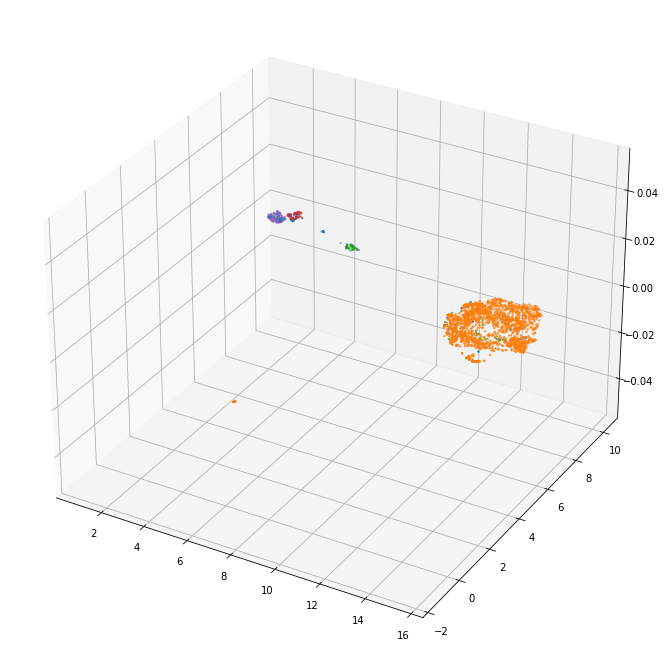

In [61]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(projection='3d')

for name, group in groups:
    plt.scatter(group.x, group.y, group.z, marker='.', label=name)

plt.savefig('umap_embedding.png')

### Penalty Codes by Cluster

In [62]:
cluster0['penaltyCodes'].value_counts()

no penalty    1812
DOF             19
ILF              5
RNK              2
UNR              1
UNRd             1
Name: penaltyCodes, dtype: int64

In [63]:
cluster1['penaltyCodes'].value_counts()

no penalty    132
UNRd            2
DOF             2
LEA             1
Name: penaltyCodes, dtype: int64

In [64]:
cluster2['penaltyCodes'].value_counts()

no penalty    109
Name: penaltyCodes, dtype: int64

In [65]:
outliers['penaltyCodes'].value_counts()

no penalty    138
OH              1
UNRd            1
RNK             1
Name: penaltyCodes, dtype: int64

In [84]:
final_df['dc_cluster_id'] = clf.score()

### Visualize Feature Distributions

In [105]:
import numpy as np

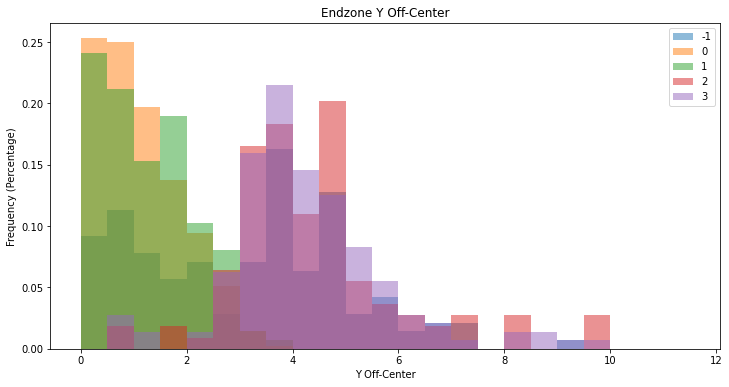

In [119]:
groups = final_df.groupby('dc_cluster_id')

plt.figure(figsize=(12,6))

for name, group in groups:
    plt.hist(group['endzone_y_off_center'], bins=np.arange(24)/2, weights=np.ones(len(group)) / len(group), label=name, alpha=0.5)

plt.title('Endzone Y Off-Center')
plt.xlabel('Y Off-Center')
plt.ylabel('Frequency (Percentage)')
plt.legend()

plt.savefig('off_center_dist.png')